In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.losses import DiceLoss

from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet,BasicUNet
from monai.networks.layers import Norm
import logging
logging.disable(logging.WARNING)

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()


MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpxxkpyi41


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
# data_dir = "/dataset/"
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


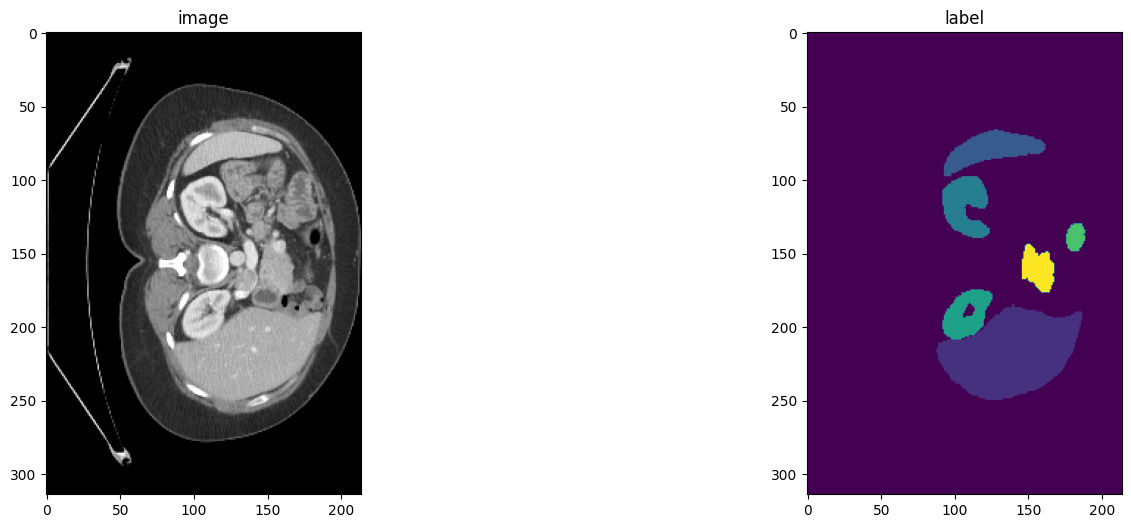

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
model = BasicUNet(spatial_dims=3,
                  in_channels=1,
                  out_channels=8,
                  features=(32, 32, 64, 128, 256, 32),
                  norm=Norm.BATCH).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# torch.backends.cudnn.benchmark = True

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 5000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold0_best_metric_model.pth")))

Training (23 / 5000 Steps) (loss=0.89916): 100%|█| 24/24 [00:12<00:00,  1.87it/s
Training (47 / 5000 Steps) (loss=0.92329): 100%|█| 24/24 [00:11<00:00,  2.09it/s
Training (71 / 5000 Steps) (loss=0.92135): 100%|█| 24/24 [00:12<00:00,  1.99it/s
Training (95 / 5000 Steps) (loss=0.87924): 100%|█| 24/24 [00:11<00:00,  2.05it/s
Training (119 / 5000 Steps) (loss=0.85119): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (143 / 5000 Steps) (loss=0.86887): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (167 / 5000 Steps) (loss=0.91944): 100%|█| 24/24 [00:11<00:00,  2.02it/
Training (191 / 5000 Steps) (loss=0.88052): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (215 / 5000 Steps) (loss=0.84131): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (239 / 5000 Steps) (loss=0.87835): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (263 / 5000 Steps) (loss=0.84080): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (287 / 5000 Steps) (loss=0.87855): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (311 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.21908897161483765 Current Avg. Dice: 0.21908897161483765


Training (503 / 5000 Steps) (loss=0.85039): 100%|█| 24/24 [00:17<00:00,  1.36it/
Training (527 / 5000 Steps) (loss=0.84577): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (551 / 5000 Steps) (loss=0.79058): 100%|█| 24/24 [00:11<00:00,  2.02it/
Training (575 / 5000 Steps) (loss=0.85627): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (599 / 5000 Steps) (loss=0.81165): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (623 / 5000 Steps) (loss=0.79752): 100%|█| 24/24 [00:11<00:00,  2.09it/
Training (647 / 5000 Steps) (loss=0.79237): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (671 / 5000 Steps) (loss=0.81992): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (695 / 5000 Steps) (loss=0.79769): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (719 / 5000 Steps) (loss=0.83386): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (743 / 5000 Steps) (loss=0.81591): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (767 / 5000 Steps) (loss=0.80459): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (791 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.41650691628456116 Current Avg. Dice: 0.41650691628456116


Training (1007 / 5000 Steps) (loss=0.87071): 100%|█| 24/24 [00:17<00:00,  1.36it
Training (1031 / 5000 Steps) (loss=0.87973): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1055 / 5000 Steps) (loss=0.74252): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1079 / 5000 Steps) (loss=0.81175): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1103 / 5000 Steps) (loss=0.80517): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1127 / 5000 Steps) (loss=0.82692): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1151 / 5000 Steps) (loss=0.72704): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1175 / 5000 Steps) (loss=0.70988): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1199 / 5000 Steps) (loss=0.77115): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1223 / 5000 Steps) (loss=0.76158): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1247 / 5000 Steps) (loss=0.69614): 100%|█| 24/24 [00:11<00:00,  2.10it
Training (1271 / 5000 Steps) (loss=0.75137): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (1295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5427745580673218 Current Avg. Dice: 0.5427745580673218


Training (1511 / 5000 Steps) (loss=0.82013): 100%|█| 24/24 [00:17<00:00,  1.33it
Training (1535 / 5000 Steps) (loss=0.66179): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (1559 / 5000 Steps) (loss=0.60672): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1583 / 5000 Steps) (loss=0.66022): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1607 / 5000 Steps) (loss=0.70201): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1631 / 5000 Steps) (loss=0.68980): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1655 / 5000 Steps) (loss=0.69043): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1679 / 5000 Steps) (loss=0.52022): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1703 / 5000 Steps) (loss=0.80462): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1727 / 5000 Steps) (loss=0.65307): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1751 / 5000 Steps) (loss=0.81153): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (1775 / 5000 Steps) (loss=0.65623): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (1799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6223556995391846 Current Avg. Dice: 0.6223556995391846


Training (2015 / 5000 Steps) (loss=0.81457): 100%|█| 24/24 [00:17<00:00,  1.37it
Training (2039 / 5000 Steps) (loss=0.72702): 100%|█| 24/24 [00:11<00:00,  2.12it
Training (2063 / 5000 Steps) (loss=0.61574): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2087 / 5000 Steps) (loss=0.75979): 100%|█| 24/24 [00:11<00:00,  2.10it
Training (2111 / 5000 Steps) (loss=0.67558): 100%|█| 24/24 [00:11<00:00,  2.10it
Training (2135 / 5000 Steps) (loss=0.63572): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2159 / 5000 Steps) (loss=0.75174): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (2183 / 5000 Steps) (loss=0.73297): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2207 / 5000 Steps) (loss=0.47307): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2231 / 5000 Steps) (loss=0.75768): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2255 / 5000 Steps) (loss=0.59057): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2279 / 5000 Steps) (loss=0.56498): 100%|█| 24/24 [00:11<00:00,  2.12it
Training (2303 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7019822001457214 Current Avg. Dice: 0.7019822001457214


Training (2519 / 5000 Steps) (loss=0.66725): 100%|█| 24/24 [00:17<00:00,  1.37it
Training (2543 / 5000 Steps) (loss=0.79638): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (2567 / 5000 Steps) (loss=0.68939): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2591 / 5000 Steps) (loss=0.55918): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2615 / 5000 Steps) (loss=0.60599): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2639 / 5000 Steps) (loss=0.51835): 100%|█| 24/24 [00:11<00:00,  2.12it
Training (2663 / 5000 Steps) (loss=0.61876): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2687 / 5000 Steps) (loss=0.65421): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2711 / 5000 Steps) (loss=0.69258): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2735 / 5000 Steps) (loss=0.46643): 100%|█| 24/24 [00:11<00:00,  2.12it
Training (2759 / 5000 Steps) (loss=0.52026): 100%|█| 24/24 [00:11<00:00,  2.11it
Training (2783 / 5000 Steps) (loss=0.58273): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (2807 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7019822001457214 Current Avg. Dice: 0.624442994594574


Training (3023 / 5000 Steps) (loss=0.64178): 100%|█| 24/24 [00:17<00:00,  1.38it
Training (3047 / 5000 Steps) (loss=0.61089): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3071 / 5000 Steps) (loss=0.52953): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3095 / 5000 Steps) (loss=0.67367): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3119 / 5000 Steps) (loss=0.75803): 100%|█| 24/24 [00:11<00:00,  2.12it
Training (3143 / 5000 Steps) (loss=0.59893): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3167 / 5000 Steps) (loss=0.35394): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3191 / 5000 Steps) (loss=0.61234): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3215 / 5000 Steps) (loss=0.56991): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3239 / 5000 Steps) (loss=0.44112): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3263 / 5000 Steps) (loss=0.70810): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3287 / 5000 Steps) (loss=0.68887): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3311 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7071945071220398 Current Avg. Dice: 0.7071945071220398


Training (3503 / 5000 Steps) (loss=0.45059): 100%|█| 24/24 [00:17<00:00,  1.38it
Training (3527 / 5000 Steps) (loss=0.57695): 100%|█| 24/24 [00:11<00:00,  2.10it
Training (3551 / 5000 Steps) (loss=0.65159): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (3575 / 5000 Steps) (loss=0.55101): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (3599 / 5000 Steps) (loss=0.38823): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (3623 / 5000 Steps) (loss=0.54738): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (3647 / 5000 Steps) (loss=0.59341): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (3671 / 5000 Steps) (loss=0.67851): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (3695 / 5000 Steps) (loss=0.59097): 100%|█| 24/24 [00:11<00:00,  2.11it
Training (3719 / 5000 Steps) (loss=0.62851): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (3743 / 5000 Steps) (loss=0.61309): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3767 / 5000 Steps) (loss=0.56529): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (3791 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7819151878356934 Current Avg. Dice: 0.7819151878356934


Training (4007 / 5000 Steps) (loss=0.60670): 100%|█| 24/24 [00:17<00:00,  1.39it
Training (4031 / 5000 Steps) (loss=0.44531): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (4055 / 5000 Steps) (loss=0.79030): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4079 / 5000 Steps) (loss=0.55611): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (4103 / 5000 Steps) (loss=0.49334): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4127 / 5000 Steps) (loss=0.56614): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4151 / 5000 Steps) (loss=0.63964): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (4175 / 5000 Steps) (loss=0.36337): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (4199 / 5000 Steps) (loss=0.70369): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (4223 / 5000 Steps) (loss=0.39682): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (4247 / 5000 Steps) (loss=0.68082): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4271 / 5000 Steps) (loss=0.62973): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (4295 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7819151878356934 Current Avg. Dice: 0.7624750137329102


Training (4511 / 5000 Steps) (loss=0.52973): 100%|█| 24/24 [00:17<00:00,  1.36it
Training (4535 / 5000 Steps) (loss=0.47577): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (4559 / 5000 Steps) (loss=0.39793): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (4583 / 5000 Steps) (loss=0.49433): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (4607 / 5000 Steps) (loss=0.55059): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4631 / 5000 Steps) (loss=0.24384): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (4655 / 5000 Steps) (loss=0.68997): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (4679 / 5000 Steps) (loss=0.61072): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4703 / 5000 Steps) (loss=0.39923): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (4727 / 5000 Steps) (loss=0.50128): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (4751 / 5000 Steps) (loss=0.81675): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4775 / 5000 Steps) (loss=0.45820): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7852849960327148 Current Avg. Dice: 0.7852849960327148


Training (5015 / 5000 Steps) (loss=0.64234): 100%|█| 24/24 [00:17<00:00,  1.37it


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7853 at iteration: 5000


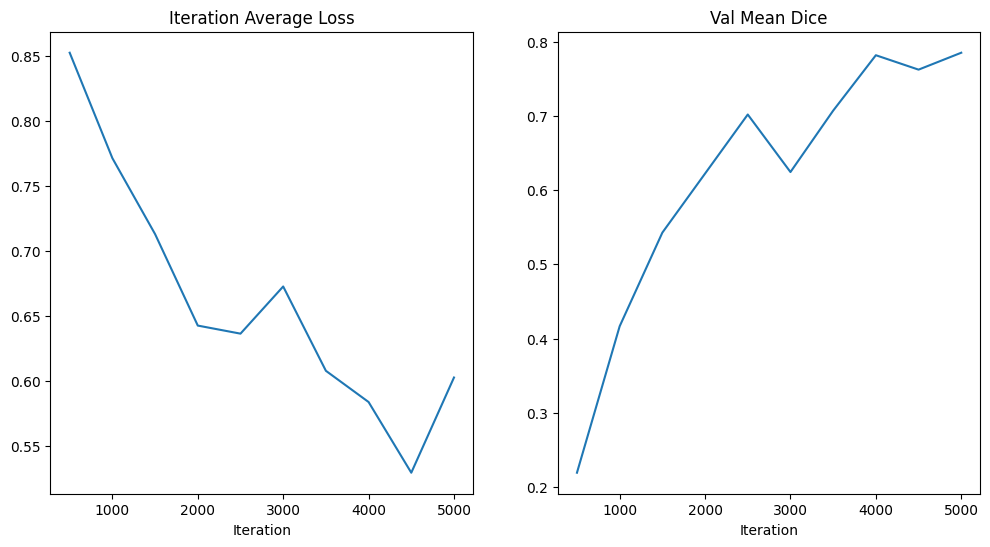

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

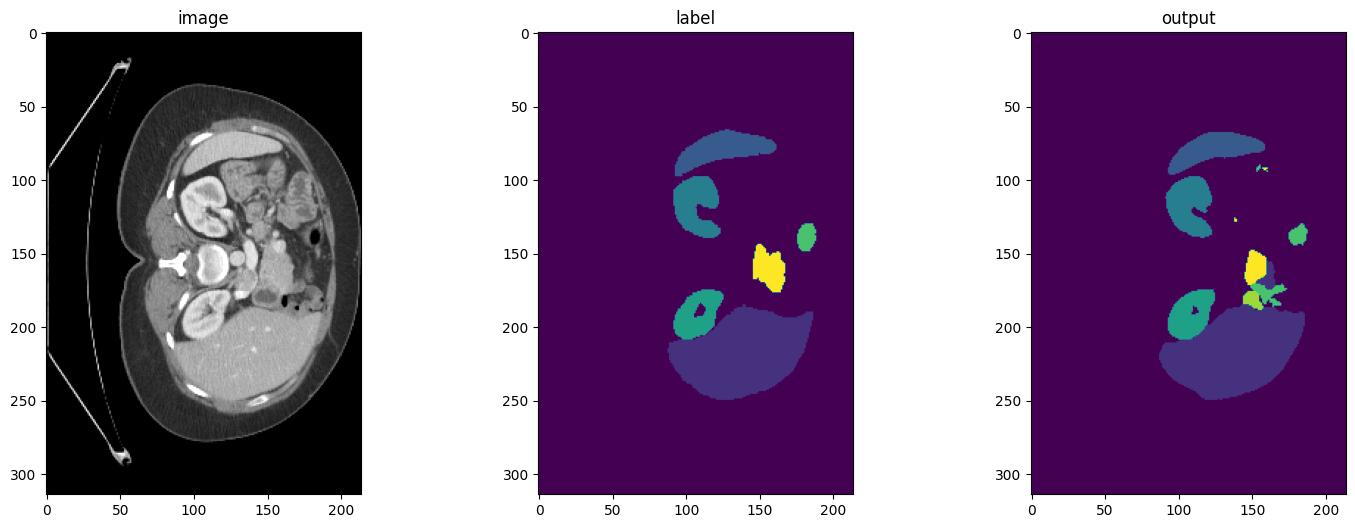

In [13]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold0_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
model = BasicUNet(spatial_dims=3,
                  in_channels=1,
                  out_channels=8,
                  features=(32, 32, 64, 128, 256, 32),
                  norm=Norm.BATCH).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# torch.backends.cudnn.benchmark = True

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 5000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold1_best_metric_model.pth")))

Training (23 / 5000 Steps) (loss=0.89126): 100%|█| 24/24 [00:12<00:00,  1.89it/s
Training (47 / 5000 Steps) (loss=0.89032): 100%|█| 24/24 [00:11<00:00,  2.05it/s
Training (71 / 5000 Steps) (loss=0.87666): 100%|█| 24/24 [00:11<00:00,  2.06it/s
Training (95 / 5000 Steps) (loss=0.90771): 100%|█| 24/24 [00:11<00:00,  2.04it/s
Training (119 / 5000 Steps) (loss=0.90014): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (143 / 5000 Steps) (loss=0.88077): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (167 / 5000 Steps) (loss=0.83788): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (191 / 5000 Steps) (loss=0.86660): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (215 / 5000 Steps) (loss=0.87083): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (239 / 5000 Steps) (loss=0.85162): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (263 / 5000 Steps) (loss=0.82674): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (287 / 5000 Steps) (loss=0.89238): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (311 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3204282224178314 Current Avg. Dice: 0.3204282224178314


Training (503 / 5000 Steps) (loss=0.86324): 100%|█| 24/24 [00:16<00:00,  1.47it/
Training (527 / 5000 Steps) (loss=0.84029): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (551 / 5000 Steps) (loss=0.89574): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (575 / 5000 Steps) (loss=0.77519): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (599 / 5000 Steps) (loss=0.89110): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (623 / 5000 Steps) (loss=0.79906): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (647 / 5000 Steps) (loss=0.81124): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (671 / 5000 Steps) (loss=0.76803): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (695 / 5000 Steps) (loss=0.87970): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (719 / 5000 Steps) (loss=0.85264): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (743 / 5000 Steps) (loss=0.86664): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (767 / 5000 Steps) (loss=0.79896): 100%|█| 24/24 [00:11<00:00,  2.02it/
Training (791 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.338252454996109 Current Avg. Dice: 0.338252454996109


Training (1007 / 5000 Steps) (loss=0.87276): 100%|█| 24/24 [00:16<00:00,  1.48it
Training (1031 / 5000 Steps) (loss=0.85967): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1055 / 5000 Steps) (loss=0.78709): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (1079 / 5000 Steps) (loss=0.85193): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (1103 / 5000 Steps) (loss=0.70770): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1127 / 5000 Steps) (loss=0.75185): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1151 / 5000 Steps) (loss=0.84533): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1175 / 5000 Steps) (loss=0.69980): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1199 / 5000 Steps) (loss=0.71115): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1223 / 5000 Steps) (loss=0.74852): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1247 / 5000 Steps) (loss=0.77018): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1271 / 5000 Steps) (loss=0.76567): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5316987037658691 Current Avg. Dice: 0.5316987037658691


Training (1511 / 5000 Steps) (loss=0.69705): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (1535 / 5000 Steps) (loss=0.65355): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1559 / 5000 Steps) (loss=0.69199): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1583 / 5000 Steps) (loss=0.67182): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1607 / 5000 Steps) (loss=0.66422): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1631 / 5000 Steps) (loss=0.71968): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1655 / 5000 Steps) (loss=0.72680): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1679 / 5000 Steps) (loss=0.80692): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1703 / 5000 Steps) (loss=0.64746): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1727 / 5000 Steps) (loss=0.64900): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (1751 / 5000 Steps) (loss=0.67621): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1775 / 5000 Steps) (loss=0.63713): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.684212863445282 Current Avg. Dice: 0.684212863445282


Training (2015 / 5000 Steps) (loss=0.82814): 100%|█| 24/24 [00:16<00:00,  1.48it
Training (2039 / 5000 Steps) (loss=0.69132): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2063 / 5000 Steps) (loss=0.73391): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2087 / 5000 Steps) (loss=0.73122): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2111 / 5000 Steps) (loss=0.59892): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2135 / 5000 Steps) (loss=0.70318): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2159 / 5000 Steps) (loss=0.72983): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2183 / 5000 Steps) (loss=0.68651): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2207 / 5000 Steps) (loss=0.68502): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2231 / 5000 Steps) (loss=0.58003): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2255 / 5000 Steps) (loss=0.66302): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2279 / 5000 Steps) (loss=0.67792): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2303 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7147658467292786 Current Avg. Dice: 0.7147658467292786


Training (2519 / 5000 Steps) (loss=0.81972): 100%|█| 24/24 [00:16<00:00,  1.48it
Training (2543 / 5000 Steps) (loss=0.76461): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2567 / 5000 Steps) (loss=0.70956): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2591 / 5000 Steps) (loss=0.46338): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2615 / 5000 Steps) (loss=0.67236): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2639 / 5000 Steps) (loss=0.70384): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (2663 / 5000 Steps) (loss=0.54944): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2687 / 5000 Steps) (loss=0.59257): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2711 / 5000 Steps) (loss=0.46250): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2735 / 5000 Steps) (loss=0.44443): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2759 / 5000 Steps) (loss=0.63501): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2783 / 5000 Steps) (loss=0.56486): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (2807 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7735238671302795 Current Avg. Dice: 0.7735238671302795


Training (3023 / 5000 Steps) (loss=0.82922): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (3047 / 5000 Steps) (loss=0.70354): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3071 / 5000 Steps) (loss=0.65541): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3095 / 5000 Steps) (loss=0.63337): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3119 / 5000 Steps) (loss=0.46426): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3143 / 5000 Steps) (loss=0.45873): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3167 / 5000 Steps) (loss=0.83144): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3191 / 5000 Steps) (loss=0.66775): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3215 / 5000 Steps) (loss=0.60121): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3239 / 5000 Steps) (loss=0.51185): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3263 / 5000 Steps) (loss=0.59632): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3287 / 5000 Steps) (loss=0.42148): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3311 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7866973280906677 Current Avg. Dice: 0.7866973280906677


Training (3503 / 5000 Steps) (loss=0.66044): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (3527 / 5000 Steps) (loss=0.86678): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3551 / 5000 Steps) (loss=0.64193): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3575 / 5000 Steps) (loss=0.51903): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3599 / 5000 Steps) (loss=0.49836): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3623 / 5000 Steps) (loss=0.45482): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3647 / 5000 Steps) (loss=0.52902): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3671 / 5000 Steps) (loss=0.57599): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3695 / 5000 Steps) (loss=0.62580): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3719 / 5000 Steps) (loss=0.55940): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (3743 / 5000 Steps) (loss=0.47063): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3767 / 5000 Steps) (loss=0.76968): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3791 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7866973280906677 Current Avg. Dice: 0.7564627528190613


Training (4007 / 5000 Steps) (loss=0.76365): 100%|█| 24/24 [00:16<00:00,  1.49it
Training (4031 / 5000 Steps) (loss=0.64085): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4055 / 5000 Steps) (loss=0.68228): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4079 / 5000 Steps) (loss=0.67840): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4103 / 5000 Steps) (loss=0.53175): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4127 / 5000 Steps) (loss=0.68561): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4151 / 5000 Steps) (loss=0.87996): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4175 / 5000 Steps) (loss=0.69089): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4199 / 5000 Steps) (loss=0.46134): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4223 / 5000 Steps) (loss=0.60746): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4247 / 5000 Steps) (loss=0.40213): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4271 / 5000 Steps) (loss=0.46702): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8133640885353088 Current Avg. Dice: 0.8133640885353088


Training (4511 / 5000 Steps) (loss=0.71297): 100%|█| 24/24 [00:16<00:00,  1.47it
Training (4535 / 5000 Steps) (loss=0.61756): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4559 / 5000 Steps) (loss=0.34827): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4583 / 5000 Steps) (loss=0.57002): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4607 / 5000 Steps) (loss=0.47089): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4631 / 5000 Steps) (loss=0.50007): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4655 / 5000 Steps) (loss=0.68579): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4679 / 5000 Steps) (loss=0.51607): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4703 / 5000 Steps) (loss=0.71129): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (4727 / 5000 Steps) (loss=0.71559): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (4751 / 5000 Steps) (loss=0.37078): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4775 / 5000 Steps) (loss=0.59087): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8201249241828918 Current Avg. Dice: 0.8201249241828918


Training (5015 / 5000 Steps) (loss=0.80312): 100%|█| 24/24 [00:16<00:00,  1.47it


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8201 at iteration: 5000


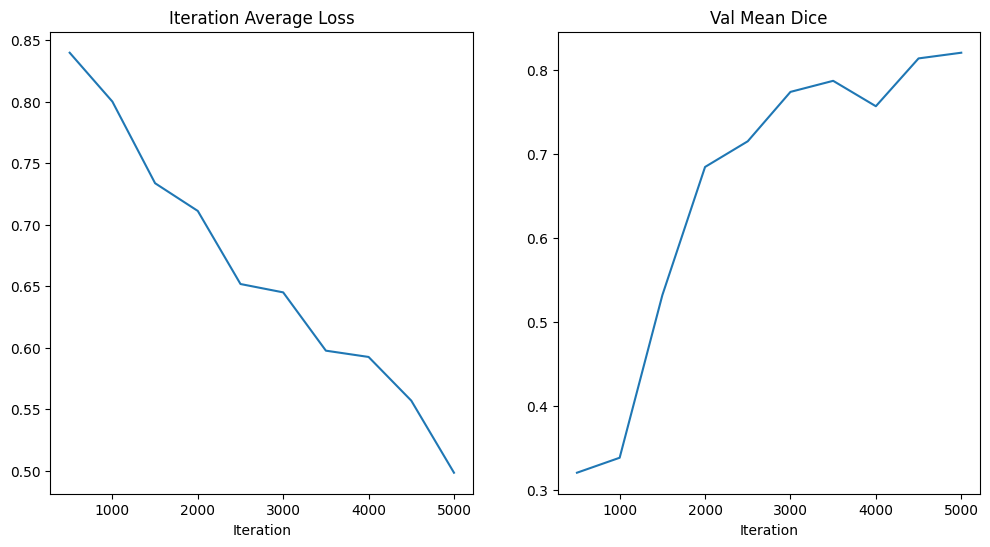

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold2 
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
model = BasicUNet(spatial_dims=3,
                  in_channels=1,
                  out_channels=8,
                  features=(32, 32, 64, 128, 256, 32),
                  norm=Norm.BATCH).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# torch.backends.cudnn.benchmark = True

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 5000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold2_best_metric_model.pth")))

Training (23 / 5000 Steps) (loss=0.91461): 100%|█| 24/24 [00:12<00:00,  1.90it/s
Training (47 / 5000 Steps) (loss=0.90654): 100%|█| 24/24 [00:11<00:00,  2.06it/s
Training (71 / 5000 Steps) (loss=0.89993): 100%|█| 24/24 [00:11<00:00,  2.07it/s
Training (95 / 5000 Steps) (loss=0.95099): 100%|█| 24/24 [00:11<00:00,  2.01it/s
Training (119 / 5000 Steps) (loss=0.87840): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (143 / 5000 Steps) (loss=0.87313): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (167 / 5000 Steps) (loss=0.89208): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (191 / 5000 Steps) (loss=0.94213): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (215 / 5000 Steps) (loss=0.91180): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (239 / 5000 Steps) (loss=0.86850): 100%|█| 24/24 [00:11<00:00,  2.02it/
Training (263 / 5000 Steps) (loss=0.86452): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (287 / 5000 Steps) (loss=0.88159): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (311 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.2482195645570755 Current Avg. Dice: 0.2482195645570755


Training (503 / 5000 Steps) (loss=0.88807): 100%|█| 24/24 [00:17<00:00,  1.40it/
Training (527 / 5000 Steps) (loss=0.80967): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (551 / 5000 Steps) (loss=0.76855): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (575 / 5000 Steps) (loss=0.80316): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (599 / 5000 Steps) (loss=0.83081): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (623 / 5000 Steps) (loss=0.83131): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (647 / 5000 Steps) (loss=0.84962): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (671 / 5000 Steps) (loss=0.82015): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (695 / 5000 Steps) (loss=0.88752): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (719 / 5000 Steps) (loss=0.82784): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (743 / 5000 Steps) (loss=0.89622): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (767 / 5000 Steps) (loss=0.71968): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (791 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3783528506755829 Current Avg. Dice: 0.3783528506755829


Training (1007 / 5000 Steps) (loss=0.76770): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (1031 / 5000 Steps) (loss=0.75081): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1055 / 5000 Steps) (loss=0.78446): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1079 / 5000 Steps) (loss=0.82134): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (1103 / 5000 Steps) (loss=0.74553): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1127 / 5000 Steps) (loss=0.73275): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1151 / 5000 Steps) (loss=0.73803): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1175 / 5000 Steps) (loss=0.75266): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1199 / 5000 Steps) (loss=0.76503): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1223 / 5000 Steps) (loss=0.76978): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1247 / 5000 Steps) (loss=0.79329): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (1271 / 5000 Steps) (loss=0.72781): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.45792460441589355 Current Avg. Dice: 0.45792460441589355


Training (1511 / 5000 Steps) (loss=0.74563): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (1535 / 5000 Steps) (loss=0.59007): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1559 / 5000 Steps) (loss=0.89313): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1583 / 5000 Steps) (loss=0.62730): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1607 / 5000 Steps) (loss=0.58192): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1631 / 5000 Steps) (loss=0.73155): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1655 / 5000 Steps) (loss=0.66666): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1679 / 5000 Steps) (loss=0.64203): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1703 / 5000 Steps) (loss=0.73515): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1727 / 5000 Steps) (loss=0.67710): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1751 / 5000 Steps) (loss=0.68871): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1775 / 5000 Steps) (loss=0.49252): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5009167790412903 Current Avg. Dice: 0.5009167790412903


Training (2015 / 5000 Steps) (loss=0.81376): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (2039 / 5000 Steps) (loss=0.63073): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2063 / 5000 Steps) (loss=0.62468): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2087 / 5000 Steps) (loss=0.58191): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (2111 / 5000 Steps) (loss=0.69160): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2135 / 5000 Steps) (loss=0.68080): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2159 / 5000 Steps) (loss=0.50602): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2183 / 5000 Steps) (loss=0.58226): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2207 / 5000 Steps) (loss=0.87124): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2231 / 5000 Steps) (loss=0.60226): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2255 / 5000 Steps) (loss=0.61000): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2279 / 5000 Steps) (loss=0.51799): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2303 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6046009063720703 Current Avg. Dice: 0.6046009063720703


Training (2519 / 5000 Steps) (loss=0.78728): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (2543 / 5000 Steps) (loss=0.44501): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2567 / 5000 Steps) (loss=0.77629): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2591 / 5000 Steps) (loss=0.64658): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2615 / 5000 Steps) (loss=0.79486): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2639 / 5000 Steps) (loss=0.67028): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2663 / 5000 Steps) (loss=0.54363): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2687 / 5000 Steps) (loss=0.68138): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (2711 / 5000 Steps) (loss=0.48736): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2735 / 5000 Steps) (loss=0.64422): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (2759 / 5000 Steps) (loss=0.49756): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (2783 / 5000 Steps) (loss=0.59935): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2807 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6721987128257751 Current Avg. Dice: 0.6721987128257751


Training (3023 / 5000 Steps) (loss=0.80622): 100%|█| 24/24 [00:16<00:00,  1.45it
Training (3047 / 5000 Steps) (loss=0.46957): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3071 / 5000 Steps) (loss=0.43230): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3095 / 5000 Steps) (loss=0.48682): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3119 / 5000 Steps) (loss=0.56743): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3143 / 5000 Steps) (loss=0.53476): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3167 / 5000 Steps) (loss=0.75123): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3191 / 5000 Steps) (loss=0.45926): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (3215 / 5000 Steps) (loss=0.58215): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3239 / 5000 Steps) (loss=0.53569): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3263 / 5000 Steps) (loss=0.78086): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3287 / 5000 Steps) (loss=0.66284): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3311 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.6721987128257751 Current Avg. Dice: 0.6187565326690674


Training (3503 / 5000 Steps) (loss=0.53701): 100%|█| 24/24 [00:16<00:00,  1.45it
Training (3527 / 5000 Steps) (loss=0.70782): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3551 / 5000 Steps) (loss=0.69795): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3575 / 5000 Steps) (loss=0.64721): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3599 / 5000 Steps) (loss=0.64198): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3623 / 5000 Steps) (loss=0.41544): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3647 / 5000 Steps) (loss=0.51530): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3671 / 5000 Steps) (loss=0.72462): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3695 / 5000 Steps) (loss=0.62412): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (3719 / 5000 Steps) (loss=0.69598): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3743 / 5000 Steps) (loss=0.63236): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3767 / 5000 Steps) (loss=0.44915): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (3791 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.674767017364502 Current Avg. Dice: 0.674767017364502


Training (4007 / 5000 Steps) (loss=0.50947): 100%|█| 24/24 [00:16<00:00,  1.45it
Training (4031 / 5000 Steps) (loss=0.59907): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4055 / 5000 Steps) (loss=0.62009): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4079 / 5000 Steps) (loss=0.69111): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4103 / 5000 Steps) (loss=0.64426): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4127 / 5000 Steps) (loss=0.58215): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4151 / 5000 Steps) (loss=0.61238): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4175 / 5000 Steps) (loss=0.36178): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4199 / 5000 Steps) (loss=0.53357): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4223 / 5000 Steps) (loss=0.74150): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4247 / 5000 Steps) (loss=0.34530): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4271 / 5000 Steps) (loss=0.61616): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7140817642211914 Current Avg. Dice: 0.7140817642211914


Training (4511 / 5000 Steps) (loss=0.40702): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (4535 / 5000 Steps) (loss=0.56913): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4559 / 5000 Steps) (loss=0.42330): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4583 / 5000 Steps) (loss=0.55990): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4607 / 5000 Steps) (loss=0.41792): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4631 / 5000 Steps) (loss=0.54445): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4655 / 5000 Steps) (loss=0.47721): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4679 / 5000 Steps) (loss=0.48335): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4703 / 5000 Steps) (loss=0.52774): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4727 / 5000 Steps) (loss=0.76123): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4751 / 5000 Steps) (loss=0.65396): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4775 / 5000 Steps) (loss=0.38621): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4799 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7140817642211914 Current Avg. Dice: 0.688256561756134


Training (5015 / 5000 Steps) (loss=0.41014): 100%|█| 24/24 [00:16<00:00,  1.46it


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7141 at iteration: 4500


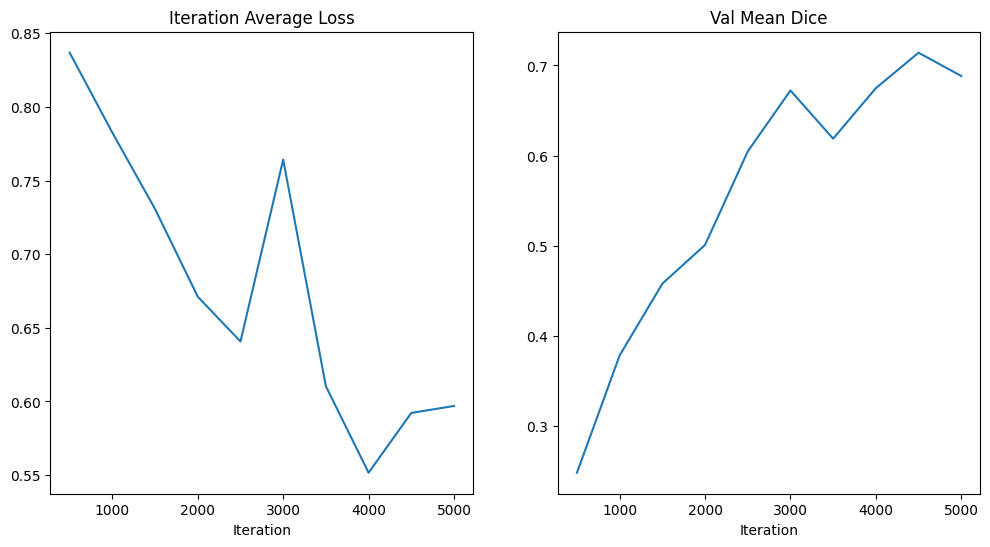

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
model = BasicUNet(spatial_dims=3,
                  in_channels=1,
                  out_channels=8,
                  features=(32, 32, 64, 128, 256, 32),
                  norm=Norm.BATCH).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# torch.backends.cudnn.benchmark = True

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 5000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold3_best_metric_model.pth")))

Training (23 / 5000 Steps) (loss=0.91105): 100%|█| 24/24 [00:12<00:00,  1.91it/s
Training (47 / 5000 Steps) (loss=0.91867): 100%|█| 24/24 [00:11<00:00,  2.06it/s
Training (71 / 5000 Steps) (loss=0.87499): 100%|█| 24/24 [00:11<00:00,  2.08it/s
Training (95 / 5000 Steps) (loss=0.90686): 100%|█| 24/24 [00:11<00:00,  2.01it/s
Training (119 / 5000 Steps) (loss=0.91121): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (143 / 5000 Steps) (loss=0.91087): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (167 / 5000 Steps) (loss=0.86226): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (191 / 5000 Steps) (loss=0.90638): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (215 / 5000 Steps) (loss=0.91886): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (239 / 5000 Steps) (loss=0.86620): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (263 / 5000 Steps) (loss=0.81367): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (287 / 5000 Steps) (loss=0.90323): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (311 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.2830609977245331 Current Avg. Dice: 0.2830609977245331


Training (503 / 5000 Steps) (loss=0.87747): 100%|█| 24/24 [00:16<00:00,  1.45it/
Training (527 / 5000 Steps) (loss=0.83099): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (551 / 5000 Steps) (loss=0.84698): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (575 / 5000 Steps) (loss=0.85692): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (599 / 5000 Steps) (loss=0.84405): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (623 / 5000 Steps) (loss=0.83499): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (647 / 5000 Steps) (loss=0.76628): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (671 / 5000 Steps) (loss=0.84241): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (695 / 5000 Steps) (loss=0.80076): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (719 / 5000 Steps) (loss=0.73947): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (743 / 5000 Steps) (loss=0.78072): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (767 / 5000 Steps) (loss=0.82835): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (791 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3103577494621277 Current Avg. Dice: 0.3103577494621277


Training (1007 / 5000 Steps) (loss=0.81694): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (1031 / 5000 Steps) (loss=0.85925): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1055 / 5000 Steps) (loss=0.77605): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1079 / 5000 Steps) (loss=0.79605): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1103 / 5000 Steps) (loss=0.78859): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1127 / 5000 Steps) (loss=0.81969): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1151 / 5000 Steps) (loss=0.67616): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1175 / 5000 Steps) (loss=0.63327): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (1199 / 5000 Steps) (loss=0.66621): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1223 / 5000 Steps) (loss=0.71487): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1247 / 5000 Steps) (loss=0.83373): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1271 / 5000 Steps) (loss=0.68337): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.38062790036201477 Current Avg. Dice: 0.38062790036201477


Training (1511 / 5000 Steps) (loss=0.84694): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (1535 / 5000 Steps) (loss=0.70053): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1559 / 5000 Steps) (loss=0.72506): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1583 / 5000 Steps) (loss=0.58705): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1607 / 5000 Steps) (loss=0.65303): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1631 / 5000 Steps) (loss=0.64929): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1655 / 5000 Steps) (loss=0.68547): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1679 / 5000 Steps) (loss=0.67856): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1703 / 5000 Steps) (loss=0.82482): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1727 / 5000 Steps) (loss=0.75974): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1751 / 5000 Steps) (loss=0.71549): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1775 / 5000 Steps) (loss=0.70105): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5547115206718445 Current Avg. Dice: 0.5547115206718445


Training (2015 / 5000 Steps) (loss=0.77968): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (2039 / 5000 Steps) (loss=0.59529): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (2063 / 5000 Steps) (loss=0.66659): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2087 / 5000 Steps) (loss=0.65970): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2111 / 5000 Steps) (loss=0.52578): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2135 / 5000 Steps) (loss=0.87957): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2159 / 5000 Steps) (loss=0.72336): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2183 / 5000 Steps) (loss=0.64233): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2207 / 5000 Steps) (loss=0.66620): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2231 / 5000 Steps) (loss=0.70646): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2255 / 5000 Steps) (loss=0.56229): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2279 / 5000 Steps) (loss=0.68873): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2303 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5609350204467773 Current Avg. Dice: 0.5609350204467773


Training (2519 / 5000 Steps) (loss=0.72419): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (2543 / 5000 Steps) (loss=0.81018): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2567 / 5000 Steps) (loss=0.54559): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2591 / 5000 Steps) (loss=0.62054): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2615 / 5000 Steps) (loss=0.74552): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2639 / 5000 Steps) (loss=0.60030): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2663 / 5000 Steps) (loss=0.44353): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2687 / 5000 Steps) (loss=0.73823): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2711 / 5000 Steps) (loss=0.53418): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2735 / 5000 Steps) (loss=0.45422): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2759 / 5000 Steps) (loss=0.53863): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2783 / 5000 Steps) (loss=0.64829): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2807 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5735487937927246 Current Avg. Dice: 0.5735487937927246


Training (3023 / 5000 Steps) (loss=0.53544): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (3047 / 5000 Steps) (loss=0.59256): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (3071 / 5000 Steps) (loss=0.56530): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3095 / 5000 Steps) (loss=0.65144): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3119 / 5000 Steps) (loss=0.68739): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3143 / 5000 Steps) (loss=0.55897): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3167 / 5000 Steps) (loss=0.46018): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3191 / 5000 Steps) (loss=0.65489): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3215 / 5000 Steps) (loss=0.78467): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3239 / 5000 Steps) (loss=0.55591): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3263 / 5000 Steps) (loss=0.54448): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3287 / 5000 Steps) (loss=0.47775): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3311 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6418158411979675 Current Avg. Dice: 0.6418158411979675


Training (3503 / 5000 Steps) (loss=0.40710): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (3527 / 5000 Steps) (loss=0.70484): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3551 / 5000 Steps) (loss=0.59537): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3575 / 5000 Steps) (loss=0.66465): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3599 / 5000 Steps) (loss=0.48593): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (3623 / 5000 Steps) (loss=0.59267): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3647 / 5000 Steps) (loss=0.52485): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3671 / 5000 Steps) (loss=0.39001): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3695 / 5000 Steps) (loss=0.50805): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3719 / 5000 Steps) (loss=0.62083): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3743 / 5000 Steps) (loss=0.62909): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3767 / 5000 Steps) (loss=0.53415): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3791 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6437845826148987 Current Avg. Dice: 0.6437845826148987


Training (4007 / 5000 Steps) (loss=0.74575): 100%|█| 24/24 [00:16<00:00,  1.42it
Training (4031 / 5000 Steps) (loss=0.48309): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4055 / 5000 Steps) (loss=0.77015): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4079 / 5000 Steps) (loss=0.67431): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4103 / 5000 Steps) (loss=0.41958): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (4127 / 5000 Steps) (loss=0.51481): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4151 / 5000 Steps) (loss=0.43443): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (4175 / 5000 Steps) (loss=0.58216): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4199 / 5000 Steps) (loss=0.53006): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4223 / 5000 Steps) (loss=0.66057): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4247 / 5000 Steps) (loss=0.45845): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4271 / 5000 Steps) (loss=0.61171): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (4295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6554943919181824 Current Avg. Dice: 0.6554943919181824


Training (4511 / 5000 Steps) (loss=0.44044): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (4535 / 5000 Steps) (loss=0.70396): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4559 / 5000 Steps) (loss=0.44007): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4583 / 5000 Steps) (loss=0.54810): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4607 / 5000 Steps) (loss=0.40765): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4631 / 5000 Steps) (loss=0.67896): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4655 / 5000 Steps) (loss=0.58991): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (4679 / 5000 Steps) (loss=0.36724): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4703 / 5000 Steps) (loss=0.54296): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (4727 / 5000 Steps) (loss=0.46039): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4751 / 5000 Steps) (loss=0.82289): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4775 / 5000 Steps) (loss=0.74209): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4799 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.6554943919181824 Current Avg. Dice: 0.6501157283782959


Training (5015 / 5000 Steps) (loss=0.70870): 100%|█| 24/24 [00:16<00:00,  1.46it


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.6555 at iteration: 4500


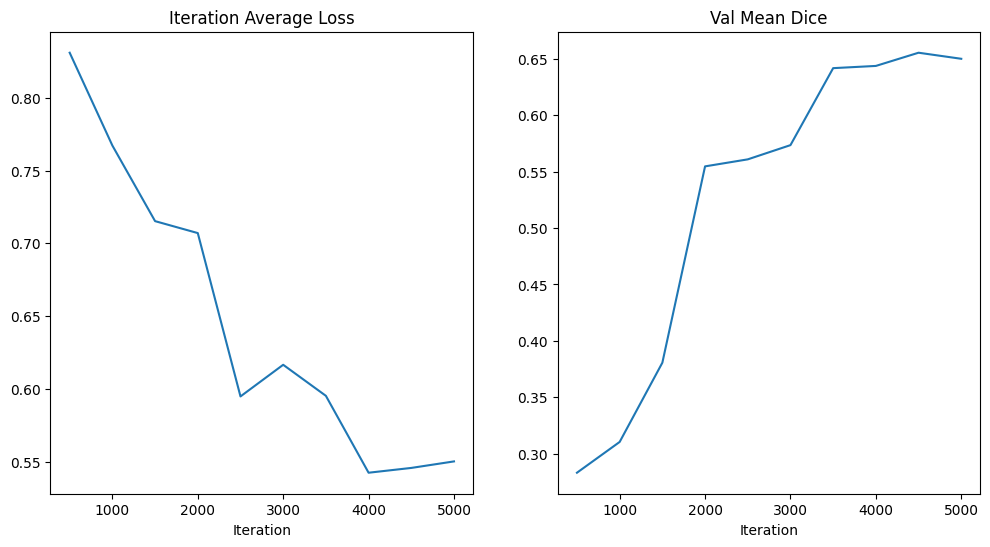

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
model = BasicUNet(spatial_dims=3,
                  in_channels=1,
                  out_channels=8,
                  features=(32, 32, 64, 128, 256, 32),
                  norm=Norm.BATCH).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# torch.backends.cudnn.benchmark = True

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 5000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/unet_model", "unetfold4_best_metric_model.pth")))

Training (23 / 5000 Steps) (loss=0.89018): 100%|█| 24/24 [00:12<00:00,  1.90it/s
Training (47 / 5000 Steps) (loss=0.89077): 100%|█| 24/24 [00:11<00:00,  2.06it/s
Training (71 / 5000 Steps) (loss=0.87828): 100%|█| 24/24 [00:11<00:00,  2.06it/s
Training (95 / 5000 Steps) (loss=0.86519): 100%|█| 24/24 [00:11<00:00,  2.02it/s
Training (119 / 5000 Steps) (loss=0.86605): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (143 / 5000 Steps) (loss=0.84212): 100%|█| 24/24 [00:11<00:00,  2.09it/
Training (167 / 5000 Steps) (loss=0.83551): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (191 / 5000 Steps) (loss=0.82418): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (215 / 5000 Steps) (loss=0.90205): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (239 / 5000 Steps) (loss=0.85347): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (263 / 5000 Steps) (loss=0.90987): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (287 / 5000 Steps) (loss=0.85495): 100%|█| 24/24 [00:11<00:00,  2.08it/
Training (311 / 5000 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.30060258507728577 Current Avg. Dice: 0.30060258507728577


Training (503 / 5000 Steps) (loss=0.77670): 100%|█| 24/24 [00:15<00:00,  1.51it/
Training (527 / 5000 Steps) (loss=0.83027): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (551 / 5000 Steps) (loss=0.80838): 100%|█| 24/24 [00:11<00:00,  2.04it/
Training (575 / 5000 Steps) (loss=0.83787): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (599 / 5000 Steps) (loss=0.86471): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (623 / 5000 Steps) (loss=0.79235): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (647 / 5000 Steps) (loss=0.80929): 100%|█| 24/24 [00:11<00:00,  2.03it/
Training (671 / 5000 Steps) (loss=0.82930): 100%|█| 24/24 [00:11<00:00,  2.07it/
Training (695 / 5000 Steps) (loss=0.84102): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (719 / 5000 Steps) (loss=0.82624): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (743 / 5000 Steps) (loss=0.81793): 100%|█| 24/24 [00:11<00:00,  2.06it/
Training (767 / 5000 Steps) (loss=0.78099): 100%|█| 24/24 [00:11<00:00,  2.05it/
Training (791 / 5000 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.30060258507728577 Current Avg. Dice: 0.289804607629776


Training (1007 / 5000 Steps) (loss=0.78966): 100%|█| 24/24 [00:15<00:00,  1.52it
Training (1031 / 5000 Steps) (loss=0.70803): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1055 / 5000 Steps) (loss=0.79979): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1079 / 5000 Steps) (loss=0.80697): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1103 / 5000 Steps) (loss=0.72047): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1127 / 5000 Steps) (loss=0.73433): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (1151 / 5000 Steps) (loss=0.69598): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1175 / 5000 Steps) (loss=0.78401): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1199 / 5000 Steps) (loss=0.80856): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1223 / 5000 Steps) (loss=0.81440): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1247 / 5000 Steps) (loss=0.67506): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1271 / 5000 Steps) (loss=0.80684): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (1295 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.538709282875061 Current Avg. Dice: 0.538709282875061


Training (1511 / 5000 Steps) (loss=0.70297): 100%|█| 24/24 [00:15<00:00,  1.52it
Training (1535 / 5000 Steps) (loss=0.65630): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1559 / 5000 Steps) (loss=0.68879): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1583 / 5000 Steps) (loss=0.80225): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1607 / 5000 Steps) (loss=0.67031): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (1631 / 5000 Steps) (loss=0.63320): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (1655 / 5000 Steps) (loss=0.69578): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1679 / 5000 Steps) (loss=0.55145): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1703 / 5000 Steps) (loss=0.76029): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1727 / 5000 Steps) (loss=0.57083): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (1751 / 5000 Steps) (loss=0.76110): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1775 / 5000 Steps) (loss=0.69072): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (1799 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5482747554779053 Current Avg. Dice: 0.5482747554779053


Training (2015 / 5000 Steps) (loss=0.71210): 100%|█| 24/24 [00:15<00:00,  1.51it
Training (2039 / 5000 Steps) (loss=0.65891): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2063 / 5000 Steps) (loss=0.69333): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2087 / 5000 Steps) (loss=0.64462): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2111 / 5000 Steps) (loss=0.74288): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2135 / 5000 Steps) (loss=0.62549): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2159 / 5000 Steps) (loss=0.56345): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2183 / 5000 Steps) (loss=0.61784): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2207 / 5000 Steps) (loss=0.61990): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2231 / 5000 Steps) (loss=0.77446): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2255 / 5000 Steps) (loss=0.52047): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2279 / 5000 Steps) (loss=0.69017): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2303 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6024558544158936 Current Avg. Dice: 0.6024558544158936


Training (2519 / 5000 Steps) (loss=0.76473): 100%|█| 24/24 [00:16<00:00,  1.49it
Training (2543 / 5000 Steps) (loss=0.71779): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2567 / 5000 Steps) (loss=0.71548): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2591 / 5000 Steps) (loss=0.55300): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2615 / 5000 Steps) (loss=0.73262): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2639 / 5000 Steps) (loss=0.83451): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2663 / 5000 Steps) (loss=0.74315): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (2687 / 5000 Steps) (loss=0.84073): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2711 / 5000 Steps) (loss=0.66311): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (2735 / 5000 Steps) (loss=0.56082): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (2759 / 5000 Steps) (loss=0.55244): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (2783 / 5000 Steps) (loss=0.60652): 100%|█| 24/24 [00:11<00:00,  2.03it
Training (2807 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.6539724469184875 Current Avg. Dice: 0.6539724469184875


Training (3023 / 5000 Steps) (loss=0.71850): 100%|█| 24/24 [00:15<00:00,  1.51it
Training (3047 / 5000 Steps) (loss=0.64195): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3071 / 5000 Steps) (loss=0.53718): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3095 / 5000 Steps) (loss=0.58243): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3119 / 5000 Steps) (loss=0.69301): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3143 / 5000 Steps) (loss=0.69378): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3167 / 5000 Steps) (loss=0.58878): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3191 / 5000 Steps) (loss=0.54582): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3215 / 5000 Steps) (loss=0.75919): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3239 / 5000 Steps) (loss=0.44271): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3263 / 5000 Steps) (loss=0.60931): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3287 / 5000 Steps) (loss=0.29230): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3311 / 5000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7146282196044922 Current Avg. Dice: 0.7146282196044922


Training (3503 / 5000 Steps) (loss=0.66581): 100%|█| 24/24 [00:15<00:00,  1.51it
Training (3527 / 5000 Steps) (loss=0.54029): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3551 / 5000 Steps) (loss=0.61390): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3575 / 5000 Steps) (loss=0.55906): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3599 / 5000 Steps) (loss=0.70011): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3623 / 5000 Steps) (loss=0.44946): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3647 / 5000 Steps) (loss=0.40258): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (3671 / 5000 Steps) (loss=0.73551): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3695 / 5000 Steps) (loss=0.68053): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (3719 / 5000 Steps) (loss=0.38421): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (3743 / 5000 Steps) (loss=0.60233): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3767 / 5000 Steps) (loss=0.54727): 100%|█| 24/24 [00:11<00:00,  2.04it
Training (3791 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7146282196044922 Current Avg. Dice: 0.6583531498908997


Training (4007 / 5000 Steps) (loss=0.70711): 100%|█| 24/24 [00:15<00:00,  1.52it
Training (4031 / 5000 Steps) (loss=0.54961): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4055 / 5000 Steps) (loss=0.59170): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4079 / 5000 Steps) (loss=0.79485): 100%|█| 24/24 [00:11<00:00,  2.06it
Training (4103 / 5000 Steps) (loss=0.66988): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4127 / 5000 Steps) (loss=0.64016): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4151 / 5000 Steps) (loss=0.43457): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4175 / 5000 Steps) (loss=0.44061): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4199 / 5000 Steps) (loss=0.45655): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4223 / 5000 Steps) (loss=0.51209): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4247 / 5000 Steps) (loss=0.68919): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4271 / 5000 Steps) (loss=0.54307): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4295 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7146282196044922 Current Avg. Dice: 0.6534380316734314


Training (4511 / 5000 Steps) (loss=0.68766): 100%|█| 24/24 [00:15<00:00,  1.52it
Training (4535 / 5000 Steps) (loss=0.47116): 100%|█| 24/24 [00:11<00:00,  2.05it
Training (4559 / 5000 Steps) (loss=0.51994): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4583 / 5000 Steps) (loss=0.50769): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4607 / 5000 Steps) (loss=0.58382): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4631 / 5000 Steps) (loss=0.52285): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4655 / 5000 Steps) (loss=0.40314): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4679 / 5000 Steps) (loss=0.60167): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (4703 / 5000 Steps) (loss=0.71398): 100%|█| 24/24 [00:11<00:00,  2.08it
Training (4727 / 5000 Steps) (loss=0.60953): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4751 / 5000 Steps) (loss=0.67028): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4775 / 5000 Steps) (loss=0.51770): 100%|█| 24/24 [00:11<00:00,  2.09it
Training (4799 / 5000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7146282196044922 Current Avg. Dice: 0.6727523803710938


Training (5015 / 5000 Steps) (loss=0.51906): 100%|█| 24/24 [00:15<00:00,  1.52it


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7146 at iteration: 3500


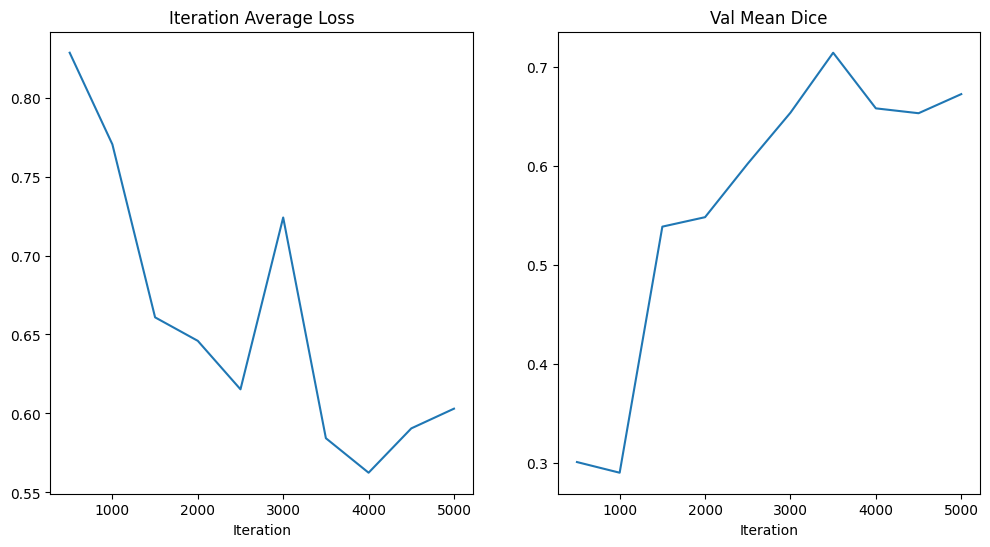

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()